# **<center><font style="color:rgb(100,109,254)">Creating a Full-Fledge Exercise Monitoring System</font> </center>**


## **<font style="color:rgb(134,19,348)"> Module Outline </font>**

The module can be split into the following parts:

- *1: Create a Pose Landmarks Detector*

- ***2:* Compute Angles between Body Joints** 

- *3: Build the Final Application*

Alright, let's get started.

In [1]:
import cv2
import math
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from previous_lesson import detectPoseLandmarks
from importlib.metadata import version
print(f"Mediapipe version: {version('mediapipe')}, it should be 0.8.9.1")

Mediapipe version: 0.8.9.1, it should be 0.8.9.1


## **<font style="color:rgb(134,19,348)">Initialize the Pose Detection Model</font>**

After that, we will have to initialize the **`mp.solutions.pose`** class and then set up the **`mp.solutions.pose.Pose()`** function (for images and videos as well) with appropriate arguments, as we had done in the previous lesson.

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Set up the pose landmarks function for images.
pose_images = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True,
                           min_detection_confidence=0.8)

# Set up the pose landmarks function for videos.
pose_videos = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True,
                           enable_segmentation=True, smooth_segmentation=True, 
                           min_detection_confidence=0.5, min_tracking_confidence=0.8)

## **<font style="color:rgb(134,19,348)">Create a Function to Calculate Angle between Landmarks</font>**

Now we will create a function **`calculateAngle()`** that we will utilize to compute angles between different body joints and depending upon those angles we will (in the next lesson) monitor different exercises of the prominent person in an image/frame in real-time.

<center><img src='https://drive.google.com/uc?export=download&id=1lhAcgq2jy5NavGQeYjTwwEAZIu6Aeypg' width=500></center>

But this approach does have a drawback that limits its use to a controlled environment, the calculated angles vary with the angle between the person and the camera. So the person needs to be facing the camera straight to get the best results.


The function **`calculateAngle()`** will need three landmarks points as these are the minimum number of points required to make two lines and it will be the same as calculating an angle between two lines. The first point (landmark) will be the starting point of the first line, the second point (landmark) will be the ending point of the first line and the starting point of the second line as well, and the third point (landmark) will be the ending point of the second line.

<center><img src='https://drive.google.com/uc?export=download&id=1KSN2OnenNMZ7Jwai_E1jeWdP5Mzay3Ad' width=400></center>

In [3]:
def calculateAngle(image, landmarks, draw=True, display=True):
    '''
    This function calculates angle between three different landmarks.
    Args:
        image:    The image on which the three points are.
        landmark: The x, y coordinates of the first, second and the third landmark.
        draw:     A boolean value that is if set to true the function draws the points and the lines  
                  joining the points along with an arc between the lines on the image.
        display:  A boolean value that is if set to true the function writes the calculated angle 
                  on the output image, displays the output image and returns nothing.
    Returns:
        angle: The calculated angle between the three landmarks points on the imaghe.
    '''
    
    # Get the height and width of the image.
    height, width, _ = image.shape
    
    # Get the three landmarks x and y coordinates.
    (x1, y1), (x2, y2), (x3, y3) = landmarks

    # Calculate the angle between the three points
    angle = round(math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2)), 1)
    
    # Check if the angle is less than zero.
    if angle < 0:

        # Add 360 to the found angle.
        angle += 360
    
    # Check if the points and the the lines joining the points are specified to be drawn.
    if draw:
            
        # Draw lines between the three points on the image. 
        cv2.line(image, pt1=(x1, y1), pt2=(x2, y2), color=(255, 0, 255), thickness=4)
        cv2.line(image, pt1=(x2, y2), pt2=(x3, y3), color=(255, 0, 255), thickness=4)
        
        # Draw circles on the points on the image.
        cv2.circle(image, center=(int(x1), int(y1)), radius=15, color=(0, 255, 0), thickness=-1)
        cv2.circle(image, center=(int(x2), int(y2)), radius=15, color=(0, 255, 0), thickness=-1)
        cv2.circle(image, center=(int(x3), int(y3)), radius=15, color=(0, 255, 0), thickness=-1)
        
        # Draw an arc between the two lines.
        ####################################################################################################
        
        # Get the starting and ending points of the arc.
        start_point = int((3/4*x2)+(1/4*x1)), int((3/4*y2)+(1/4*y1))
        end_point = int((3/4*x2)+(1/4*x3)), int((3/4*y2)+(1/4*y3))
        
        # Calculate the radius of the arc.
        radius = int(np.sqrt((start_point[0]-end_point[0])*(start_point[0]-end_point[0]) 
                             + (start_point[1]-end_point[1])*(start_point[1]-end_point[1]))) 
        
        # Calculate the starting and ending angles of the elliptic arc in degrees.
        # Starting angle is where you want to start drawing your arc. (This will be 0 if you want to draw a complete circle).
        # Ending angle is where you want to stop drawing your arc. (This will be 360 if you want to draw a complete circle).
        start_angle = int((180/math.pi*math.atan2(start_point[1]-y2, start_point[0]-x2)))
        end_angle = int((180/math.pi*math.atan2(end_point[1]-y2, end_point[0]-x2)))
        
        # Check if starting angle is greater than ending angle.
        # then we have to draw elliptic arc in counterclockwise direction.
        if start_angle > end_angle:
            
            # Subtract 360 from the absolute value of the ending angle.
            # This is required to draw the elliptic arc in counterclockwise direction.
            end_angle = 360 - abs(end_angle)
        
        # Draw the the elliptic arc between the two lines on the image.
        cv2.ellipse(image, center=(x2, y2), axes=(radius, radius), 
                    angle=0., startAngle=start_angle, endAngle=end_angle, color=(0, 255, 0), thickness=10)
        
        ####################################################################################################

    # Check if the image is specified to be displayed.
    if display:
        
        # Write the calculated angle on the frame. 
        cv2.putText(image, f'ANGLE: {angle}', (10, int(height/20)),
                    cv2.FONT_HERSHEY_PLAIN, int(width/350), (255, 255, 0), int(width/200))
        
        # Display the resultant image.
        plt.figure(figsize=[10,10])
        plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise.
    else:
    
        # Return the output image and the calculated angle.
        return image, angle

Now we will check if the function **`calculateAngle()`** created above, is working or not, by calculating the angle between three random points on a few sample images.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


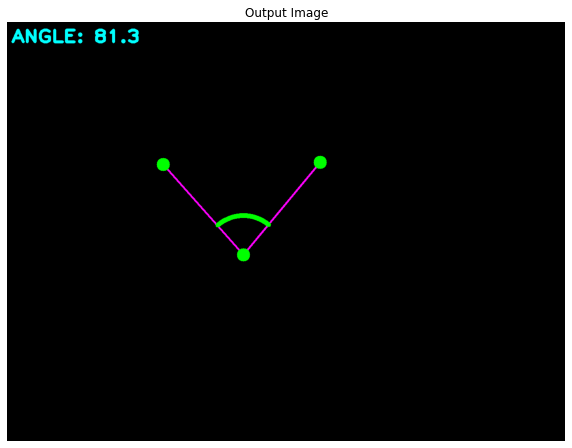

In [4]:
# Calculate the angle between the three landmarks and display the results.
image = np.zeros((960, 1280, 3), np.uint8)
pt1 = (358, 326)
pt2 = (542, 533)
pt3 = (718, 321)
angle = calculateAngle(image, (pt1, pt2, pt3))

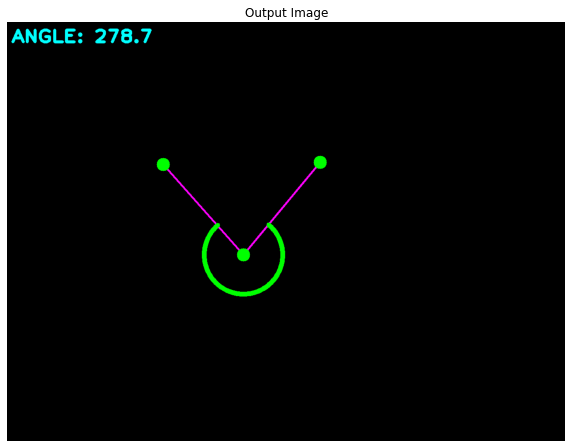

In [5]:
# Calculate the angle between the three landmarks and display the results.
image = np.zeros((960, 1280, 3), np.uint8)
angle = calculateAngle(image, (pt3, pt2, pt1))

Working perfectly fine! and as we saw that the order in which we pass the points also matters. Now, let's test it on a real-time webcam feed to calculate the angles between the right and left `SHOULDER`, `ELBOW`, and `WRIST` coordinates. We will first have to perform the pose detection using the **`detectPoseLandmarks()`** function that we had created in the previous lesson and then we will pass the appropriate landmarks points to the **`calculateAngle()`** function created above, to compute angles between different body joints.

In [7]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
        
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform Pose landmarks detection on the frame.
    frame, pose_landmarks = detectPoseLandmarks(frame, pose_videos,  draw=False, display=False)
    
    # Check if the pose landmarks are detected.
    if len(pose_landmarks) > 0:
    
        # Calculate the angle between the right shoulder, elbow and wrist points. 
        frame, right_arm_angle = calculateAngle(frame, (pose_landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value],
                                                        pose_landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                                        pose_landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]), display=False)

        # Calculate the angle between the left shoulder, elbow and wrist points. 
        frame, left_arm_angle = calculateAngle(frame, (pose_landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                                        pose_landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                                        pose_landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]), display=False)
    # Otherwise.
    else:
        
        # Set the right and left arm angle to None.
        right_arm_angle = None
        left_arm_angle = None
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Check if the right and left arm angle are found.
    if right_arm_angle and left_arm_angle:
        
        # Write the calculated left arm angle on the frame. 
        cv2.putText(frame, f'LEFT ARM ANGLE: {left_arm_angle}', (10, int(frame_height/20)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/430), (0, 255, 0), int(frame_width/430))

        # Write the calculated right arm angle on the frame. 
        cv2.putText(frame, f'RIGHT ARM ANGLE: {right_arm_angle}', (int(frame_width/1.5), int(frame_height/20)),
                    cv2.FONT_HERSHEY_PLAIN, int(frame_width/430), (0, 255, 0), int(frame_width/430))
        
    # Display the frame.
    cv2.imshow('Webcam Feed', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if (k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

Working as expected on a real-time webcam feed as well.